# Analyse campagnes marketing client
Dans ce Notebook, nous retrouverez l'ensemble des analyses exploratoires, modèles prédictifs et clusterings client effectués pour justifier notre chiffrage de
l’efficacité des campagnes marketing et cerner la cible client du magasin.

Pour faire fonctionner ce Notebook, nous devons au préalable importer certaines bibliothèques Python :

In [50]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
from datetime import date

Avant de pouvoir analyser notre jeu de données, nous devons d'abord le récupérer dans le fichier .csv "Camp_Market" :

In [51]:
df = pd.read_csv("Camp_Market.csv", sep=';')

## 1 - Nettoyage et organisation des données

Pour commencer, nous avons nettoyé les données pour comprendre leur structure et les informations qu'elles contiennent. Certaines colonnes de notre jeu de données contiennent des variables catégorielles, comme c'est le cas pour `Education`. Afin d'effectuer notre analyse exploratoire, nous avons besoin de convertir ces variables catégorielles en valeurs numériques.

Dans cette optique, nous avons restructuré notre jeu de données : grâce au One-Hot, nous avons pu convertir nos valeurs catégorielles en valeurs numériques dans le but de faciliter l'analyse.

In [52]:
# Encodage One-Hot
data_encoded = pd.get_dummies(df, columns=['Education'])

Nous avons ensuite créé huit nouvelles colonnes numériques contenant les nouvelles valeurs :

In [53]:
#var Living_with
def love_status(status):
    if status == "Single" or status == "Widow" or status == "Divorced":
        return 'Single'
    elif status == "Together" or status == "Married":
        return 'In a relationship'
data_encoded["Living_with"] = df["Marital_Status"].apply(love_status)

#var Family_size
data_encoded["Family_size"] = data_encoded["Kidhome"] + np.where(
    (data_encoded["Marital_Status"] == "Together") | (data_encoded["Marital_Status"] == "Married"), 
    2, 
    1
)

# var Customer_for nombre de jours depuis que le client a commencé ses achats au magasin depuis la dernière date enregistrée
today = pd.Timestamp(datetime.date.today())
data_encoded["Customer_for"] = (today - pd.to_datetime(df["Dt_Customer"])).dt.days

# var Age
data_encoded["Age"] = date.today().year - data_encoded["Year_Birth"]

#var Spend
data_encoded["Spent"] = data_encoded[[col for col in df.columns if col.startswith('Mnt')]].sum(axis=1)

#var Is_parent
data_encoded["Is_parent"] = np.where((data_encoded["Kidhome"] > 0) | (data_encoded["Teenhome"] > 0), 1, 0)

#var Children
data_encoded["Children"] = data_encoded.Kidhome + data_encoded.Teenhome

#var Education
def edu_level(level):
    if (level == "Master" or level == "Phd") :
        return 2
    elif(level == "Graduation") :
        return 1
    else :
        return 0

data_encoded["Education2"] = df["Education"].apply(edu_level)

Maintenant que l'on a les colonnes qui nous intéressent, nous supprimons les colonnes contenant nos valeurs catégorielles et remplaçons les valeurs vides "NaN" par 0 :

In [54]:
data_encoded = data_encoded.drop(columns=["Dt_Customer", "Marital_Status", "Dt_Customer", "Year_Birth", "Kidhome", "Teenhome", "Living_with", "Education_Master", "Education_PhD", "Education_Graduation", "Education_Basic", "Education_2n Cycle"])
data_encoded = data_encoded.fillna(0)

Enfin, on observe la répartition des données de chaque colonne autour de leurs médianes respectives afin de déterminer les valeurs aberrantes :



Text(0.5, 1.0, 'Graphique de répartition des valeurs par colonne')

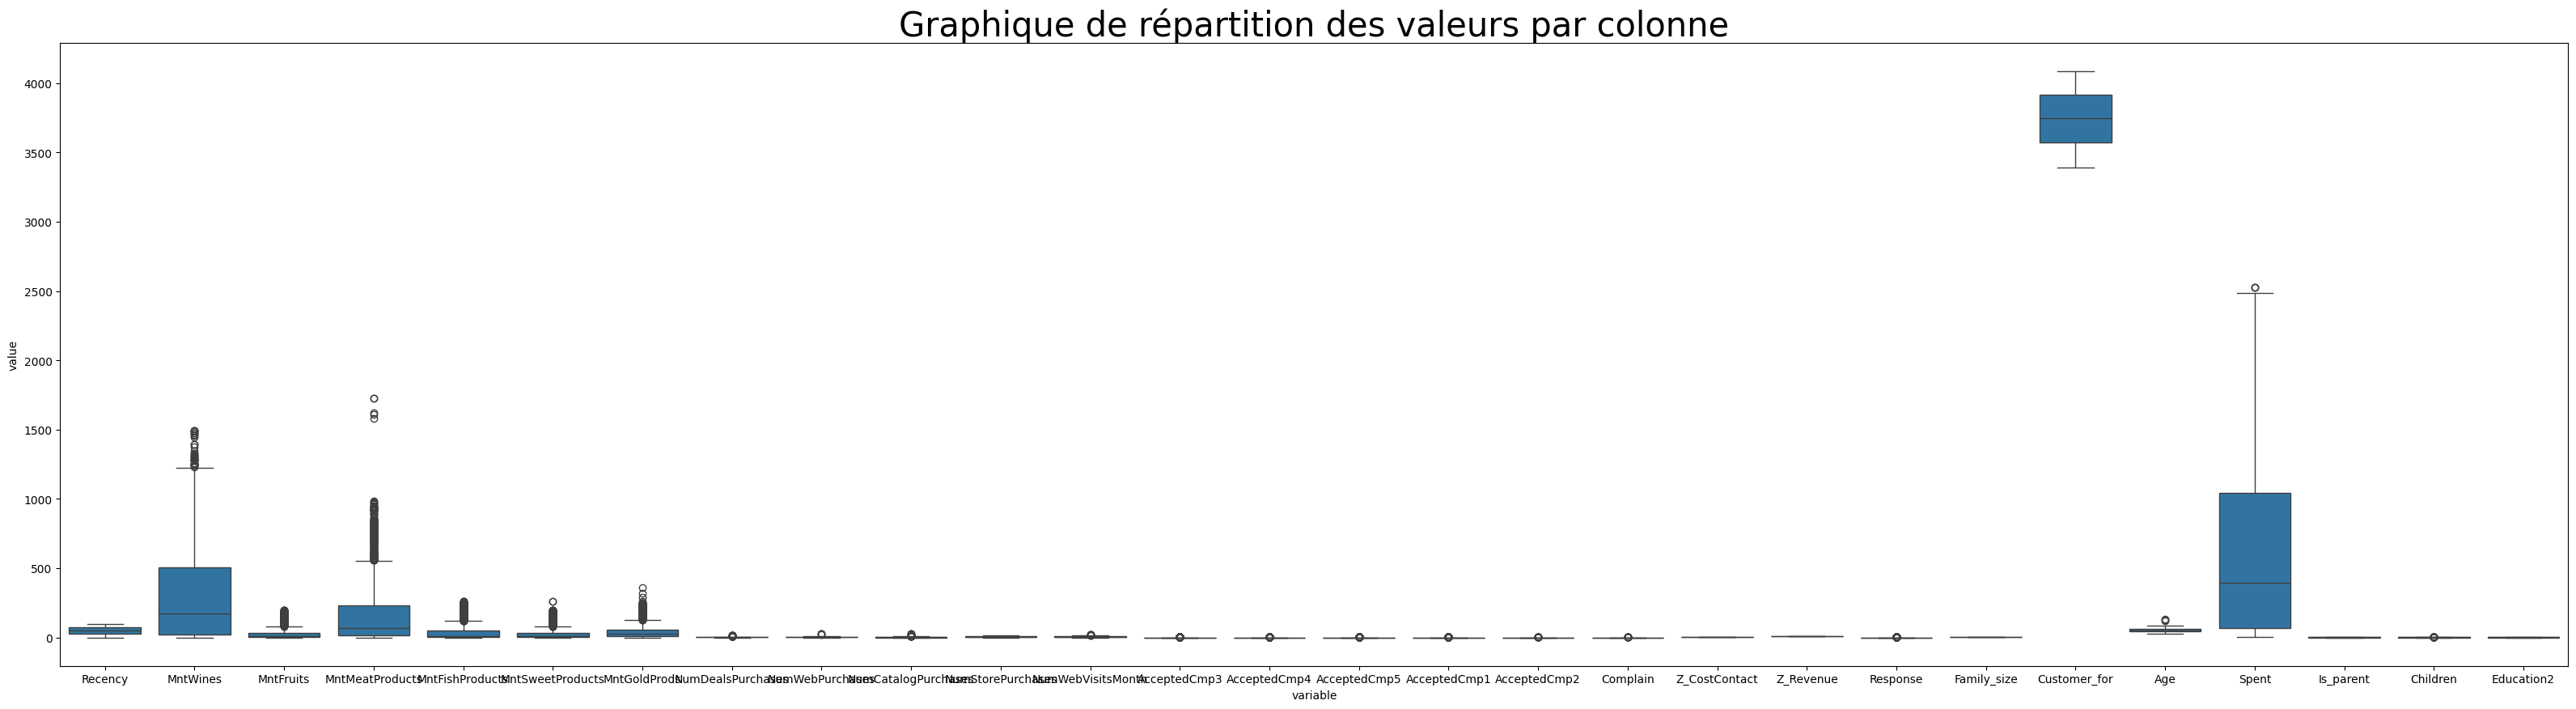

In [55]:
rcParams['figure.figsize'] = 40, 10
sns.boxplot(x='variable', y='value', data=pd.melt(data_encoded.drop(columns=["Income", "ID"])))
plt.title("Graphique de répartition des valeurs par colonne", fontsize=30)

On observe ainsi que la plupart des colonnes n'ont pas de valeurs significativement aberrantes dans le jeu.

Text(0.5, 1.0, 'Graphique de répartition des valeurs par colonne')

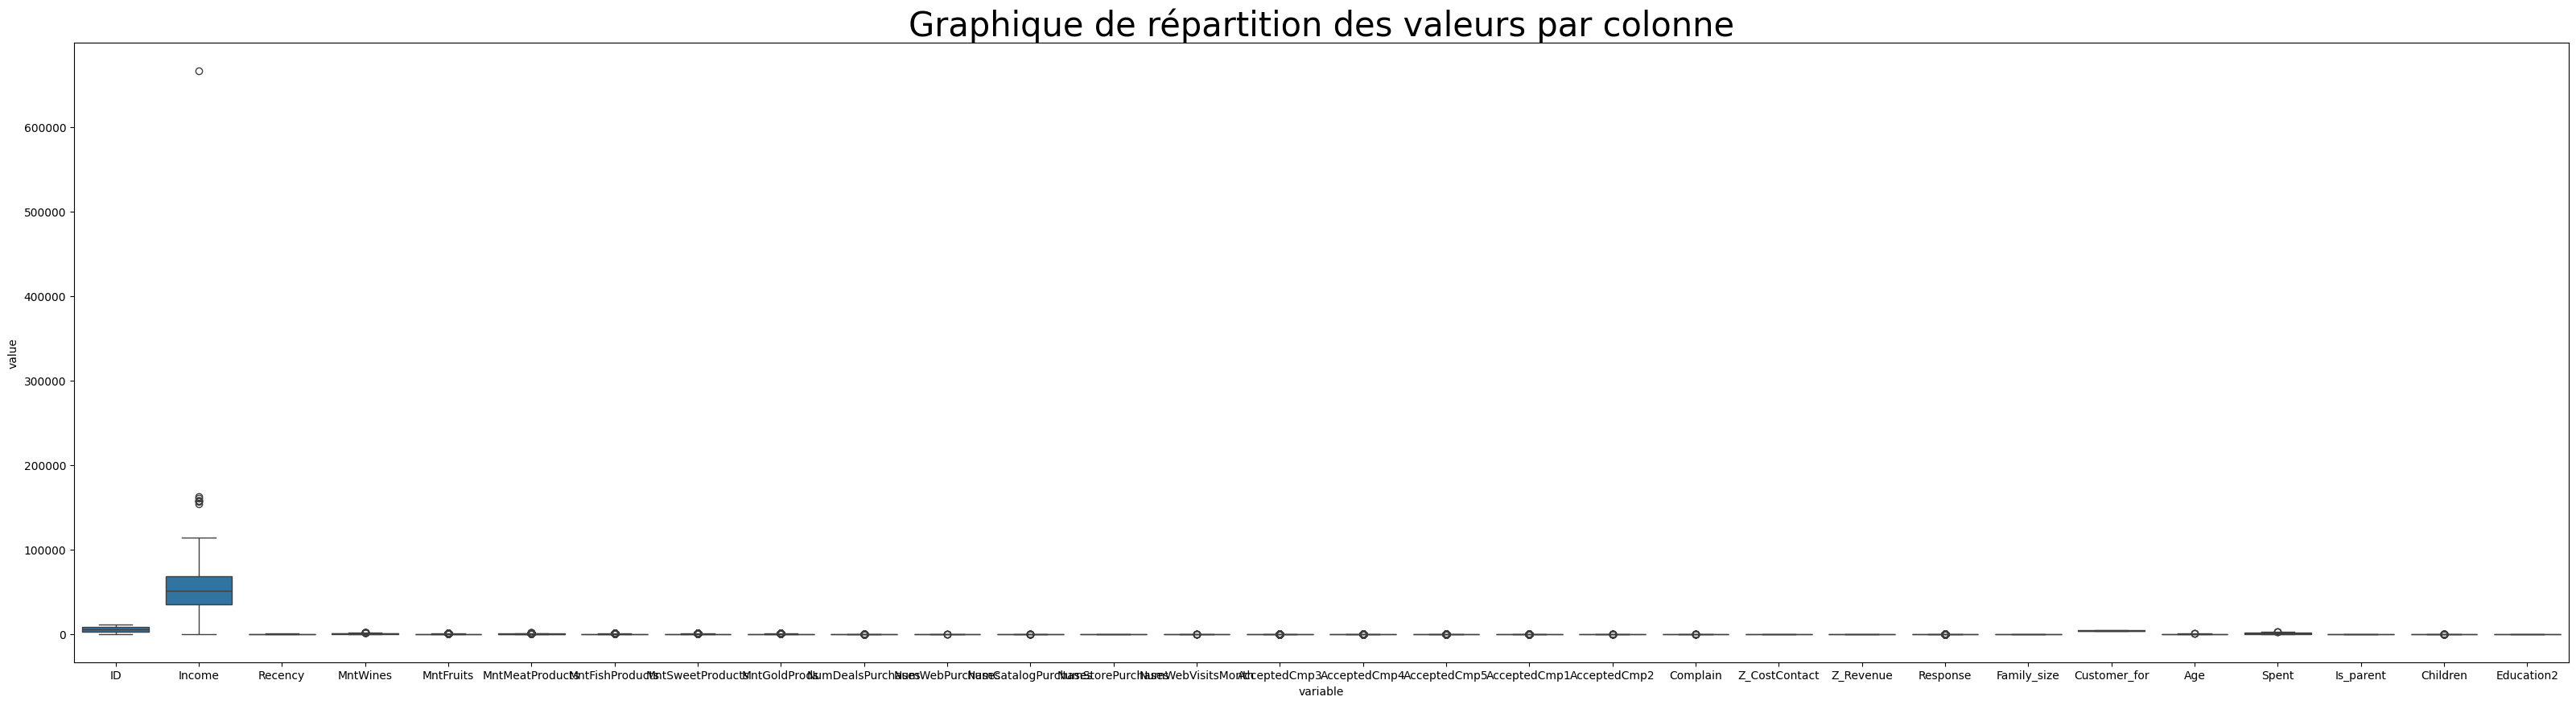

In [56]:
sns.boxplot(x='variable', y='value', data=pd.melt(data_encoded))
plt.title("Graphique de répartition des valeurs par colonne", fontsize=30)

Après observation des graphiques en boîte à moustaches, seule la catégorie `Income` (revenus) en possède une. C'est pourquoi nous avons décidé de l'exclure de notre jeu de données : 

In [57]:
data_encoded = data_encoded[data_encoded.Income < 600000]

## 2 - Analyse Exploratoire

Maintenant que nos données sont nettoyées, nous avons exploré les données pour comprendre leur structure, détecter des valeurs manquantes afin de produire des outils de visualisation des distributions des différentes variables.

Dans le cadre de notre analyse exploratoire, nous avons réalisé une matrice de corrélation pour mettre en lumière des liens entre variables :

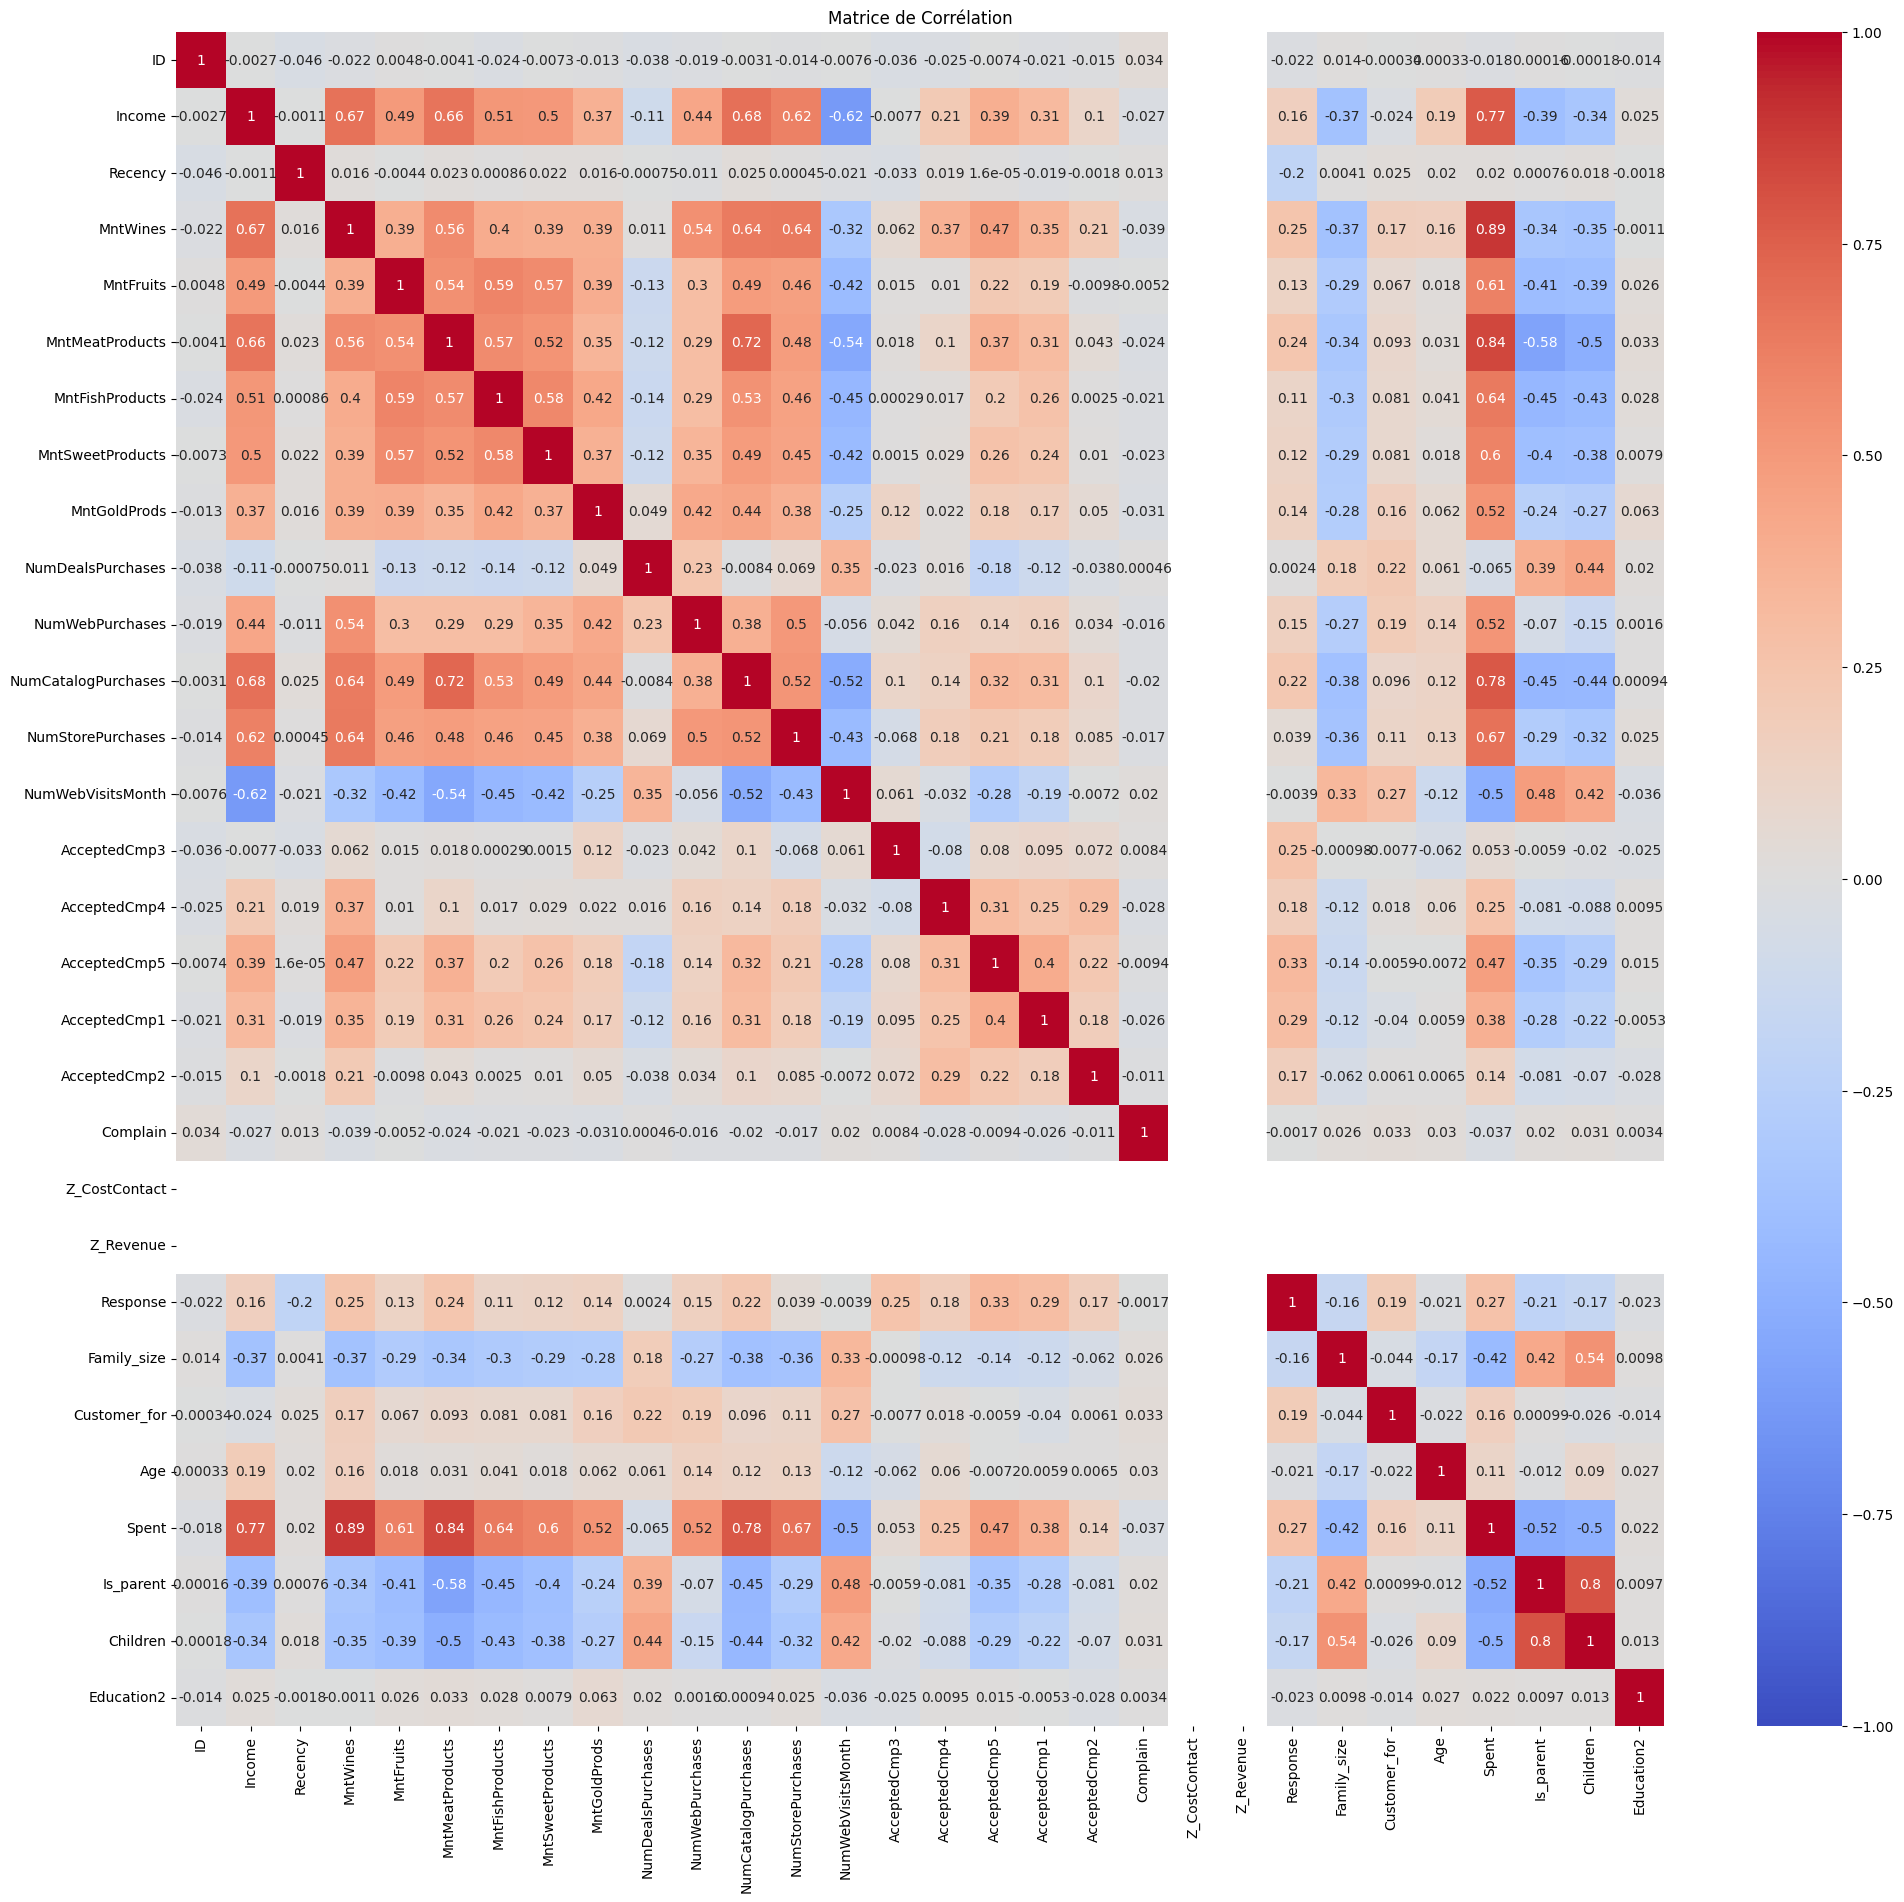

In [58]:
corr_matrix_encoded = data_encoded.corr()

plt.figure(figsize=(24, 22))
sns.heatmap(corr_matrix_encoded, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice de Corrélation")
plt.show()